# TCGA RNA-Seq RSEM normalized Collaborative Filtering

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

import pandas as pd
import numpy as np

In [3]:
path='~/data/tcga/'

## Preprocessing

### subset

In [4]:
df = pd.read_csv(path+'full.csv', sep=',', low_memory=False, index_col=[0], error_bad_lines=False); df.head()

,LOC100130426,UBE2Q2P3,UBE2Q2P2,HMGB1P1,TIMM23,MOXD2,LOC155060,RNU12-2P,SSX9,LOC317712,...,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR,cancer
TCGA-2A-A8VL-01A-21R-A37L-07,0.0,4.375165,4.117130,6.338271,10.356474,0.0,8.299844,0.000000,0.0,0.0,...,8.150981,10.105178,5.251908,9.434774,11.169806,10.539810,8.980566,7.638647,0.000000,PRAD
TCGA-2A-A8VO-01A-11R-A37L-07,0.0,4.272068,3.798102,5.955957,9.754902,0.0,8.562890,0.000000,0.0,0.0,...,8.583033,9.826347,7.387885,9.562891,11.405313,9.738158,9.323495,8.188683,0.000000,PRAD
TCGA-2A-A8VT-01A-11R-A37L-07,0.0,5.611349,5.887579,6.561063,9.186661,0.0,9.511317,0.141302,0.0,0.0,...,9.226164,10.754531,5.475257,10.217726,10.583608,11.023235,10.423672,5.171103,-1.443791,PRAD
TCGA-2A-A8VV-01A-11R-A37L-07,0.0,4.441902,4.034550,6.756879,9.843444,0.0,7.889987,0.000000,0.0,0.0,...,8.718451,9.988854,6.010740,9.259221,11.578931,10.008104,10.034888,4.404563,0.000000,PRAD
TCGA-2A-A8VX-01A-11R-A37L-07,0.0,1.561937,3.110330,6.598782,9.701914,0.0,8.341960,0.000000,0.0,0.0,...,8.486776,9.957949,7.355339,9.468424,11.149634,9.709747,9.556007,3.765927,0.000000,PRAD


In [5]:
dupabbr = ['KIPAN', 'COADREAD', 'STES', 'GBMLGG']
df = df.loc[~df['cancer'].isin(dupabbr)]
sids = list(df.index)
df = df.assign(sid=sids)
df = df.loc[df.sid.str.split('-', expand=True).loc[:,3].str[0] == str(1)]

In [6]:
df = df.reset_index(); df = df.drop(columns=['index']); df.head()

,LOC100130426,UBE2Q2P3,UBE2Q2P2,HMGB1P1,TIMM23,MOXD2,LOC155060,RNU12-2P,SSX9,LOC317712,...,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,psiTPTE22,tAKR,cancer,sid
0,0.0,3.896892,4.100860,6.780083,9.400669,0.0,6.815707,-1.126896,0.0,0.0,...,10.156281,6.890000,9.870372,11.149026,10.860101,9.391845,8.176973,0.0,PRAD,TCGA-CH-5761-11A-01R-1580-07
1,0.0,4.453195,3.944315,6.557416,9.472098,0.0,8.047926,0.000000,0.0,0.0,...,10.198511,6.278790,9.853897,11.884718,10.982852,9.634271,7.274068,0.0,PRAD,TCGA-CH-5767-11B-01R-1789-07
2,0.0,4.328542,1.698707,6.747101,9.177937,0.0,7.488902,0.000000,0.0,0.0,...,10.135936,7.114928,10.270056,10.742797,10.564287,9.840068,5.992070,0.0,PRAD,TCGA-CH-5768-11A-01R-1580-07
3,0.0,2.990047,3.867037,7.511164,9.842156,0.0,7.119329,-1.388355,0.0,0.0,...,10.231296,5.070965,9.322341,11.575876,10.209122,8.865383,5.444425,0.0,PRAD,TCGA-CH-5769-11A-01R-1580-07
4,0.0,3.555522,2.382750,7.505043,9.793781,0.0,6.892522,-1.374449,0.0,0.0,...,9.938051,6.076946,10.195591,11.513146,10.284839,9.934074,7.125581,0.0,PRAD,TCGA-EJ-7115-11A-01R-2118-07


In [7]:
len(df)

701

### Melt

In [9]:
mdf = pd.melt(df, id_vars=['sid', 'cancer'], var_name='gene', value_name='log2exp'); mdf.head()

,sid,cancer,gene,log2exp
0,TCGA-CH-5761-11A-01R-1580-07,PRAD,LOC100130426,0.0
1,TCGA-CH-5767-11B-01R-1789-07,PRAD,LOC100130426,0.0
2,TCGA-CH-5768-11A-01R-1580-07,PRAD,LOC100130426,0.0
3,TCGA-CH-5769-11A-01R-1580-07,PRAD,LOC100130426,0.0
4,TCGA-EJ-7115-11A-01R-2118-07,PRAD,LOC100130426,0.0


In [ ]:
len(mdf)

In [ ]:
#mdf.to_csv(path+'melted.csv')

## Collaborative filtering

In [ ]:
#mdf = pd.read_feather(path+'melted')

In [ ]:
#mdf.head()

In [10]:
val_idxs = get_cv_idxs(len(mdf))
wd=2e-4
n_factors = 50

In [11]:
cd = CollabFilterDataset.from_data_frame(path, mdf, 'sid', 'gene', 'log2exp')
#cf = CollabFilterDataset.from_csv(path, 'melted.csv', 'sid', 'gene', 'log2exp')
learn = cd.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [12]:
learn.lr_find()

 47%|████▋     | 84694/179903 [04:41<05:16, 300.77it/s, loss=6.83]

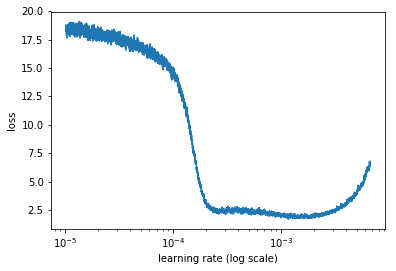

 47%|████▋     | 84694/179903 [05:00<05:37, 282.30it/s, loss=6.83]

In [13]:
learn.sched.plot(100)

In [14]:
lr=1e-4
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss                                     
    0      1.955449   2.023349  
    1      0.882158   0.870976                                      
    2      0.842584   0.765196                                      


[array([0.7652])]

In [6]:
preds = learn.predict()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


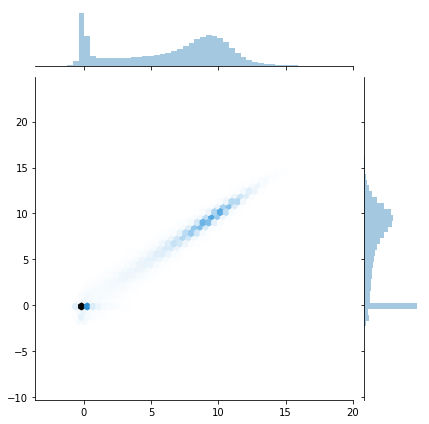

In [7]:
y=learn.data.val_y
# import seaborns as sns
sns.jointplot(preds, y, kind='hex', stat_func=None);

In [15]:
learn.save('tcga_collab_normal_new')

In [ ]:
#learn.load('tcga_collab_normal')

## Analyze results

#### shortcut to retrieve learner, model, df

In [4]:
df = pd.read_csv(path+'full.csv', sep=',', low_memory=False, index_col=[0], error_bad_lines=False); df.head()
dupabbr = ['KIPAN', 'COADREAD', 'STES', 'GBMLGG']
df = df.loc[~df['cancer'].isin(dupabbr)]
sids = list(df.index)
df = df.assign(sid=sids)
df = df.loc[df.sid.str.split('-', expand=True).loc[:,3].str[0] == str(1)]
df = df.reset_index(); df = df.drop(columns=['index']); df.head()
mdf = pd.melt(df, id_vars=['sid', 'cancer'], var_name='gene', value_name='log2exp'); mdf.head()
val_idxs = get_cv_idxs(len(mdf))
wd=2e-4
n_factors = 50
cd = CollabFilterDataset.from_data_frame(path, mdf, 'sid', 'gene', 'log2exp')
learn = cd.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)
learn.load('tcga_collab_normal_new')

In [4]:
genes = list(df.columns[:-2])
sids = list(df['sid'])
cancers = list(df['cancer'])
sid_ca = {s:c for s, c in zip(sids, cancers)}

### Embedding interpretation

### retrieve embeddings 

In [5]:
m=learn.model; m.cuda()

EmbeddingDotBias(
  (u): Embedding(701, 50)
  (i): Embedding(20531, 50)
  (ub): Embedding(701, 1)
  (ib): Embedding(20531, 1)
)

#### gene embedding

In [6]:
geneidx = np.array([cd.item2idx[g] for g in genes])
gene_emb = to_np(m.i(V(geneidx)))
gene_emb.shape

(20531, 50)

In [7]:
gene_emb_df = pd.DataFrame(gene_emb, index=genes); gene_emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
LOC100130426,-0.128957,0.078128,0.078055,-0.079232,0.095939,-0.054685,0.116152,0.126091,0.103557,-0.122399,...,-0.148355,0.120640,-0.119604,0.118698,-0.091062,0.013374,0.049280,-0.086833,0.103157,0.148730
UBE2Q2P3,0.009592,0.071021,-0.012806,-0.050346,0.053566,-0.066957,-0.006620,0.112995,-0.008716,0.024538,...,-0.069458,0.096920,-0.105437,0.068697,-0.032473,-0.094495,0.043598,-0.051522,0.048664,0.060534
UBE2Q2P2,-0.083416,0.108435,-0.055251,-0.054530,0.056255,-0.118633,-0.028719,0.041668,-0.002497,0.073667,...,-0.053094,0.122536,-0.003244,0.046027,-0.099223,-0.053502,0.038912,-0.050446,0.054780,0.086739
HMGB1P1,-0.008469,0.004490,0.034207,0.032221,-0.022021,-0.026224,-0.033156,0.001019,0.042477,-0.050837,...,-0.038974,0.005869,0.023687,-0.050556,0.073171,0.026545,0.026570,0.056794,-0.023118,0.050305
TIMM23,0.065531,-0.005739,-0.048226,0.081197,-0.105546,0.022109,-0.030867,-0.052696,-0.017001,-0.044764,...,0.035412,-0.056659,0.079777,-0.077753,0.045317,0.046712,-0.033503,0.082459,-0.071942,-0.028868


In [8]:
gene_emb_df.to_csv(path+'gene_emb_normal_new.csv', sep=',')

In [9]:
gene_emb_bias = to_np(m.ib(V(geneidx)))
gene_emb_bias_df = pd.DataFrame(gene_emb_bias, index=genes); gene_emb_bias_df.head()
gene_emb_bias_df.to_csv(path+'gene_emb_normal_new_bias.csv')

#### sample embedding 

In [10]:
sampleidx = np.array([cd.user2idx[sid] for sid in sids])
samp_emb = to_np(m.u(V(sampleidx)))
samp_emb.shape

(701, 50)

In [11]:
samp_emb_df = pd.DataFrame(samp_emb, index=sids); samp_emb_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
TCGA-CH-5761-11A-01R-1580-07,-0.155322,0.033345,-0.216273,0.320643,0.057964,-0.543414,-0.172860,-0.063233,-0.313928,0.217372,...,0.285497,-0.232799,0.064764,-0.302276,0.285508,-0.234046,-0.051302,0.050832,-0.079415,-0.315381
TCGA-CH-5767-11B-01R-1789-07,-0.044316,-0.065269,-0.211365,0.331902,0.048430,-0.477074,-0.272162,-0.141787,-0.451776,0.218535,...,0.231139,-0.209393,0.124907,-0.271998,0.335514,-0.279820,-0.022435,0.138769,-0.144753,-0.293139
TCGA-CH-5768-11A-01R-1580-07,-0.158286,0.087131,-0.273261,0.367651,0.044509,-0.636097,-0.171456,-0.197759,-0.280121,0.196403,...,0.249233,-0.281627,0.113077,-0.311480,0.214869,-0.140429,-0.106347,0.047031,-0.115315,-0.287367
TCGA-CH-5769-11A-01R-1580-07,-0.062706,0.002588,-0.179582,0.250119,0.040033,-0.380078,-0.192765,-0.028501,-0.257210,0.197123,...,0.270543,-0.246729,0.150614,-0.342070,0.305531,-0.207685,-0.057397,0.116535,-0.107561,-0.259250
TCGA-EJ-7115-11A-01R-2118-07,-0.157511,0.012232,-0.187401,0.343240,0.063363,-0.601202,-0.175346,-0.191425,-0.317367,0.152940,...,0.197808,-0.265846,0.140845,-0.313566,0.275594,-0.146421,-0.113797,0.101728,-0.127196,-0.314129


In [12]:
samp_emb_df.to_csv(path+'samp_emb_normal_new.csv', sep=',')

In [13]:
samp_emb_bias = to_np(m.ub(V(sampleidx)))
samp_emb_bias_df = pd.DataFrame(samp_emb_bias, index=sids); samp_emb_bias_df.head()
samp_emb_bias_df.to_csv(path+'samp_emb_normal_new_bias.csv')